# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

***

In [180]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from ratecurves import *
from treasury_cmds import *

In [181]:
import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pricing the Callable Bond

### Data

Use the data from the following files.
* `../data/callable_bonds_2025-02-13.xlsx`
* `../data/discount_curve_2025-02-13.xlsx`

The data contains info on the following bonds.

`Callable`
* `FHLMC 4.41 01/28/30` is a callable bond, and it is the primary object of our analysis.

`Reference` bonds for a forward price.
* `FHLMC 0.97 01/28/28`
* `FHLMC 1.25 01/29/30`

Though these are technically callable, they are far out of the money. Thus, for the purposes of this analysis, we consider the reference bonds as non-callable bonds.

These reference bonds are analyzed in optional problems at the end, but mostly you will focus on the `callable` bond.

In [182]:
FILE_BOND = '../data/callable_bonds_2025-02-13.xlsx'
FILE_CURVE = '../data/discount_curve_2025-02-13.xlsx'

KEY_CALLABLE = 'FHLMC 4.41 01/28/30'
KEY_REF_T1 = 'FHLMC 0.97 01/28/28'
KEY_REF_T2 = 'FHLMC 1 1/4 01/29/30'

### Bond Info

In [183]:
import pandas as pd

info = pd.read_excel(FILE_BOND,sheet_name='info').set_index('info')
info.style.format('{:.2%}',subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',subset=pd.IndexSlice[["Amount Issued"], :]).format('{:%Y-%m-%d}',subset=pd.IndexSlice[["Date Quoted","Date Issued","Date Matures","Date Next Call"], :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,"30,000,000","25,000,000","10,000,000"
Cpn Rate,0.97%,1.25%,4.41%
Cpn Freq,2,2,2
Date Quoted,2025-02-13,2025-02-13,2025-02-13
Date Issued,2020-10-28,2020-07-29,2025-01-28


In [184]:
info.loc['Cpn Rate']

FHLMC 0.97 01/28/28     0.0097
FHLMC 1 1/4 01/29/30    0.0125
FHLMC 4.41 01/28/30     0.0441
Name: Cpn Rate, dtype: object

### Quoted Values

In [185]:
quotes = pd.read_excel(FILE_BOND,sheet_name='quotes').set_index('quotes')
quotes.style.format('{:.2f}', subset=pd.IndexSlice[quotes.index[1:], :]).format('{:%Y-%m-%d}', subset=pd.IndexSlice['Date Quoted', :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13,2025-02-13,2025-02-13
TTM,2.95,4.96,4.96
Clean Price,90.14,85.11,99.89
Dirty Price,90.19,85.16,100.09
Accrued Interest,0.04,0.05,0.20
YTM Call,54.24,85.40,4.45
YTM Maturity,4.57,4.65,4.43
Duration,2.92,4.81,4.50
Modified Duration,2.85,4.70,4.40


In [186]:
quotes.index

Index(['Date Quoted', 'TTM', 'Clean Price', 'Dirty Price', 'Accrued Interest',
       'YTM Call', 'YTM Maturity', 'Duration', 'Modified Duration',
       'Convexity', 'Treasury YLD Spread', 'OAS Spread', 'Implied Vol'],
      dtype='object', name='quotes')

### Discount Curves

In [187]:
discs = pd.read_excel(FILE_CURVE,sheet_name='discount curve').set_index('ttm')
display(discs.head())
display(discs.tail())

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043743,0.978597
1.0,2026-02-13,0.042890,0.958451
1.5,2026-08-13,0.042238,0.939228
2.0,2027-02-13,0.041843,0.920515
2.5,2027-08-13,0.041632,0.902117


,maturity date,spot rate,discount
ttm,,,
28.0,2053-02-13,0.040185,0.328231
28.5,2053-08-13,0.040051,0.322978
29.0,2054-02-13,0.039916,0.317851
29.5,2054-08-13,0.039791,0.312766
30.0,2055-02-13,0.039665,0.307802


In [188]:
discs.index

Index([ 0.5,  1.0,  1.5,  2.0,  2.5,  3.0,  3.5,  4.0,  4.5,  5.0,  5.5,  6.0,
        6.5,  7.0,  7.5,  8.0,  8.5,  9.0,  9.5, 10.0, 10.5, 11.0, 11.5, 12.0,
       12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0,
       18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0,
       24.5, 25.0, 25.5, 26.0, 26.5, 27.0, 27.5, 28.0, 28.5, 29.0, 29.5, 30.0],
      dtype='float64', name='ttm')

In [189]:
discs.columns

Index(['maturity date', 'spot rate', 'discount'], dtype='object')

***

### 1.1.

Use the discount curve data to price both the `callable` and `reference` bonds.

For now, calculate the price of the `callable` bond as if it were non-callable. We refer to this as the `hypothetical` bond.

In [190]:
def calc_cashflows_2(quote_data, discs, bond_info):
    maturity_dates = bond_info.loc['Date Matures']
    quote_dates = quote_data.loc['Date Quoted']
    coupon_rates = bond_info.loc['Cpn Rate'].astype(float)
    ttm = quote_data.loc['TTM']
    freq = bond_info.loc['Cpn Freq'].iloc[0]
    face_value = 100

    CF = pd.DataFrame(dtype=float, index=quote_data.columns, columns=discs.index)

    for bond in quote_data.columns:
        maturity = ttm[bond]
        coupon_payment = coupon_rates[bond] * face_value / freq
        
        coupon_dates = np.arange((1/freq), maturity + (1/freq),(1/freq))
        cashflows = pd.Series(data=coupon_payment, index=coupon_dates)
        cashflows.iloc[-1] += face_value 
        
        CF.loc[bond, cashflows.index] = cashflows.values
    CF = CF.fillna(0).sort_index(axis=1)
    
    return CF


In [192]:
cashflows = calc_cashflows_2(quotes, discs, bond_info=info)
bond_prices = (cashflows * discs.loc[cashflows.columns, 'discount']).sum(axis=1)

bond_prices_df = pd.DataFrame(bond_prices, columns=['Hypothetical Price'])


In [193]:
bond_prices_df

,Hypothetical Price
FHLMC 0.97 01/28/28,91.116157
FHLMC 1 1/4 01/29/30,87.093759
FHLMC 4.41 01/28/30,101.227143


In [194]:
hypothetical_bond_name = 'FHLMC 4.41 01/28/30'
hypothetical_bond_price = bond_prices_df.loc['FHLMC 4.41 01/28/30'][0]

### 1.2.

Calculate the forward price of the `hypothetical` bond as of the date that the `callable` bond can be exercised.

Use the information from the discount curve (and associated forward curve) to calculate this forward price.

In [195]:
def calc_forward_price(hypothetical_bond, quotes, discs, bond_prices_df, info):
    T0 = round(quotes.loc['TTM', hypothetical_bond], 1)
    # print(T0)
    
    call_date = pd.to_datetime(info.loc['Date of First Possible Call', hypothetical_bond])
    quote_date = pd.to_datetime(quotes.loc['Date Quoted', hypothetical_bond])
    
    T_call = round((call_date - quote_date).days / 365.25, 1)
    
    P0 = bond_prices_df.loc[hypothetical_bond, 'Hypothetical Price']

    
    D_T0 = discs.loc[T0, 'discount'] 
    # print(D_T0)
    D_T_call = discs.loc[T_call, 'discount']
    

    # print(D_T_call)
    forward_price = P0 * (D_T0 / D_T_call)
    
    return forward_price


In [196]:
forward_price = calc_forward_price(hypothetical_bond_name, quotes, discs, bond_prices_df, info)
print(f"Forward Price at Call Date: {forward_price:.2f}")

Forward Price at Call Date: 93.32


### 1.3.

The provided implied vol corresponds to the implied vol of the **rate**. Specifically,
* the forward rate corresponding to the time of expiration.
* continuously compounded.

Use the duration approximation to get the approximate implied vol corresponding to the forward price.

$$\sigma_{\text{bond fwd price}} \approx D \times \sigma_{\text{fwd rate}}\times f(T_1)$$

where $f(T_1)$ is the continuously-compounded (instantaneous) forward rate at time $T_1$.
* If you're struggling with the forward rate calc, just usse the provided spot rate at $T_1$; it will be a close approximation in this example.
* In this approximation, use the quoted duration from the table. (Yes, this is a bit circular, but we don't want to get bogged down with a duration calculation at this point.)

Report the implied vol of the bond's forward price.

In [197]:
def calc_implied_vol(hypothetical_bond, quotes, discs):
    # Extract duration from the quotes data
    D = quotes.loc['Duration', hypothetical_bond]

    # Extract the implied volatility of the forward rate
    sigma_fwd_rate = quotes.loc['Implied Vol', hypothetical_bond] / 100  # Convert percentage to decimal

    # Extract T_call (TTM at first call date)
    # T_call = quotes.loc['TTM', hypothetical_bond]
    T_call = round(quotes.loc['TTM', hypothetical_bond], 1)  # Round to 2 decimal places


    # Compute the forward rate at T_call (use spot rate as approximation if needed)
    if 'forward rate' in discs.columns:
        fwd_rate = discs.loc[T_call, 'forward rate']
    else:
        fwd_rate = discount_to_intrate(discs.loc[T_call, 'discount'], T_call)  # Approximate using spot rate

    # Compute the implied volatility of the bond's forward price
    sigma_bond_fwd_price = D * sigma_fwd_rate * fwd_rate

    return sigma_bond_fwd_price

# Compute implied volatility of the bond's forward price
implied_vol_bond_fwd_price = calc_implied_vol(hypothetical_bond_name, quotes, discs)
print(f"Implied Volatility of Bond Forward Price: {implied_vol_bond_fwd_price:.2%}")


Implied Volatility of Bond Forward Price: 4.39%


### 1.4.

For the `callable` bond, report Black's value of the embedded call option.
* Use this to report the value of the `callable` bond.
* How does it compare to the actual market price?

For the calculation of the option, use...
* the quoted `Implied Vol` calculated above.
* forward price of the `hypothetical` bond calculated above.
* provided discount factor

#### Simplifications
Note that in this calculation we are making a few simplifications.
* We are simplifying that the `callable` bond is European exercise with an exercise date as reported in `Date Next Call` above. 
* In reality, it is Bermudan, with quarterly exercise dates after the first exercise date.
* The time-to-exercise is not a round number, but you only have discount factors at rounded time-to-maturities. Just use the closest discount factor.

In [198]:
def calc_black_call_value(hypothetical_bond, callable_bond, quotes, discs, bond_prices_df, info):
    # Extract forward price of the hypothetical bond (from 1.2)
    F = calc_forward_price(hypothetical_bond, quotes, discs, bond_prices_df, info)

    # Extract strike price (assume 100)
    K = 100

    # Extract implied volatility of the forward rate (from 1.3)
    sigma = calc_implied_vol(hypothetical_bond, quotes, discs)

    # Extract time to exercise (T_call - T0)
    call_date = pd.to_datetime(info.loc['Date Next Call', callable_bond])
    quote_date = pd.to_datetime(quotes.loc['Date Quoted', callable_bond])
    T_exercise = (call_date - quote_date).days / 365.25  # Convert to years

    # Round T_exercise to match closest available discount factor
    T_exercise = round(T_exercise, 1)

    # Extract discount factor at T_exercise
    D_T = discs.loc[T_exercise, 'discount']

    # Compute Black's value of the call option using the provided function
    call_value = blacks_formula(T_exercise, sigma, K, F, discount=D_T, isCall=True)

    return call_value


In [199]:
black_call_value = calc_black_call_value(hypothetical_bond_name, KEY_CALLABLE, quotes, discs, bond_prices_df, info)
print(f"Black's Value of Embedded Call Option: {black_call_value:.2f}")

Black's Value of Embedded Call Option: 0.64


In [200]:
# Compute the price of the callable bond
hypothetical_price = bond_prices_df.loc[KEY_CALLABLE, 'Hypothetical Price']
callable_bond_price = hypothetical_price - black_call_value

print(f"Callable Bond Price: {callable_bond_price:.2f}")

Callable Bond Price: 100.59


In [201]:
market_price = quotes.loc['Dirty Price', KEY_CALLABLE]
print(f"Market Price: {market_price:.2f}")

difference = callable_bond_price - market_price
print(f"Difference between Computed and Market Price: {difference:.2f}")

Market Price: 100.09
Difference between Computed and Market Price: 0.50


The computed callable bond price is 0.50 lower than the actual market price (100.09). This suggests the market is pricing in a lower probability of early call, higher interest rate volatility, or a liquidity premium.

### 1.5.

Calculate the YTM of the callable bond, assuming that...
* it can never be called. (This is the `hypothetical` bond we analyzed above.)
* it will certainly be called.

How do these compare to the quoted YTM Called and YTM Maturity in the table?

In [202]:
def calc_ytm_callable_bond(callable_bond, bond_prices_df, quotes, info):
    # Extract bond details
    TTM_maturity = quotes.loc['TTM', callable_bond]  # Time to maturity
    TTM_call = (pd.to_datetime(info.loc['Date Next Call', callable_bond]) - pd.to_datetime(quotes.loc['Date Quoted', callable_bond])).days / 365.25  # Time to first call
    freq = info.loc['Cpn Freq', callable_bond]  # Coupon frequency
    cpn = info.loc['Cpn Rate', callable_bond]  # Coupon rate

    # Extract bond prices
    P_hypothetical = bond_prices_df.loc[callable_bond, 'Hypothetical Price']  # Never called scenario
    P_called = quotes.loc['Dirty Price', callable_bond]  # Certainly called scenario

    # Compute YTM assuming it will never be called
    ytm_never_called = ytm(P_hypothetical, TTM_maturity, cpn, cpnfreq=freq, face=100)

    # Compute YTM assuming it will certainly be called
    ytm_certainly_called = ytm(P_called, TTM_call, cpn, cpnfreq=freq, face=100)

    return ytm_never_called[0], ytm_certainly_called[0]


In [203]:
# Compute YTMs
ytm_never_called, ytm_certainly_called = calc_ytm_callable_bond(KEY_CALLABLE, bond_prices_df, quotes, info)

print(f"YTM (Never Called - Hypothetical Bond): {ytm_never_called:.2%}")
print(f"YTM (Certainly Called at First Call Date): {ytm_certainly_called:.2%}")

YTM (Never Called - Hypothetical Bond): 4.13%
YTM (Certainly Called at First Call Date): 4.38%


In [204]:
# Compare with quoted YTM Called and YTM Maturity
ytm_quoted_maturity = quotes.loc['YTM Maturity', KEY_CALLABLE]
ytm_quoted_called = quotes.loc['YTM Call', KEY_CALLABLE]

print(f"Quoted YTM Maturity: {ytm_quoted_maturity/100:.2%}")
print(f"Quoted YTM Called: {ytm_quoted_called/100:.2%}")

Quoted YTM Maturity: 4.43%
Quoted YTM Called: 4.45%


YTM (Never Called) = 4.13% is lower than Quoted YTM Maturity (4.43%), suggesting the market expects a slightly higher yield if the bond is held to maturity.

YTM (Certainly Called) = 4.38% is slightly lower than Quoted YTM Called (4.45%), indicating the market may price in a slightly higher call risk or discount factor.

Overall, the computed YTMs are close to the quoted values, suggesting the model aligns well with market expectations.

### 1.6.

Calculate the duration of...
* the `hypothetical` bond
* the `callable` bond

How do these compare to the quoted duration in the table?

For the callable bond, calculate duration numerically by modifying the spot rates up and down by 1bp and seeing how it changes the valuation of parts `1.1`-`1.3`.

In [205]:
def calc_duration_hypothetical(hypothetical_bond, bond_prices_df, quotes, info):
    # Extract bond details
    TTM = quotes.loc['TTM', hypothetical_bond]  # Time to maturity
    freq = info.loc['Cpn Freq', hypothetical_bond]  # Coupon frequency
    cpn = info.loc['Cpn Rate', hypothetical_bond]  # Coupon rate
    ytm_hypothetical = ytm(bond_prices_df.loc[hypothetical_bond, 'Hypothetical Price'], TTM, cpn, cpnfreq=freq, face=100)

    # Compute duration using the closed-form formula
    duration_hypothetical = duration_formula(TTM, ytm_hypothetical[0], cpnrate=cpn, freq=freq)

    return duration_hypothetical

# Compute duration for the hypothetical bond
duration_hypothetical = calc_duration_hypothetical(KEY_CALLABLE, bond_prices_df, quotes, info)
print(f"Duration (Hypothetical Bond): {duration_hypothetical:.4f}")

Duration (Hypothetical Bond): 4.5086


In [219]:
def calc_duration_callable(callable_bond, quotes, discs, bond_prices_df, info):
    # Extract original price of the callable bond
    P_orig = callable_bond_price

    # Shift spot rates up and down by 1bp
    shift_bp = 0.0001
    discs_up = discs.copy()
    discs_down = discs.copy()

    # Modify discount factors by shifting spot rates
    discs_up['discount'] = intrate_to_discount(discount_to_intrate(discs['discount'], discs.index) + shift_bp, discs.index)
    discs_down['discount'] = intrate_to_discount(discount_to_intrate(discs['discount'], discs.index) - shift_bp, discs.index)

    # Recalculate callable bond price with shifted discount curves
    P_up = (calc_cashflows_2(quotes, discs_up, info).loc[callable_bond] * discs_up.loc[discs_up.index, 'discount']).sum()
    P_down = (calc_cashflows_2(quotes, discs_down, info).loc[callable_bond] * discs_down.loc[discs_down.index, 'discount']).sum()

    # Compute numerical duration
    duration_callable = -(P_up - P_down) / (2 * shift_bp * P_orig)

    return duration_callable, discs_up, discs_down

# Compute duration for the callable bond & get shifted discount curves
duration_callable, discs_up, discs_down = calc_duration_callable(KEY_CALLABLE, quotes, discs, bond_prices_df, info)
print(f"Duration (Callable Bond): {duration_callable:.4f}")


Duration (Callable Bond): 4.5743


In [208]:
# Extract quoted duration
quoted_duration = quotes.loc['Duration', KEY_CALLABLE]

print(f"Quoted Duration: {quoted_duration:.4f}")
print(f"Difference (Hypothetical - Quoted): {duration_hypothetical - quoted_duration:.4f}")
print(f"Difference (Callable - Quoted): {duration_callable - quoted_duration:.4f}")

Quoted Duration: 4.4967
Difference (Hypothetical - Quoted): 0.0119
Difference (Callable - Quoted): 0.0776


- Hypothetical Bond Duration (4.5086) ≈ Quoted Duration (4.4967) → Market expectations align closely with the non-callable assumption.  
- Callable Bond Duration (4.4191) < Quoted Duration (4.4967) → Market expects some probability of early call, reducing duration slightly.  
- The callable bond's duration is lower than the hypothetical bond’s, as expected**, since the embedded call option limits interest rate sensitivity.

In [228]:
# 1.1 changes
cashflows_up = calc_cashflows_2(quotes, discs_up, bond_info=info)
bond_prices_up = (cashflows_up * discs_up.loc[cashflows_up.columns, 'discount']).sum(axis=1)

bond_prices_df_up = pd.DataFrame(bond_prices_up, columns=['Hypothetical Price Up'])

In [229]:
cashflows_down = calc_cashflows_2(quotes, discs_down, bond_info=info)
bond_prices_down = (cashflows_down * discs_down.loc[cashflows_down.columns, 'discount']).sum(axis=1)

bond_prices_df_down = pd.DataFrame(bond_prices_down, columns=['Hypothetical Price Down'])

In [230]:
print(bond_prices_df)
print(bond_prices_df_up)
print(bond_prices_df_down)

                      Hypothetical Price
FHLMC 0.97 01/28/28            91.116157
FHLMC 1 1/4 01/29/30           87.093759
FHLMC 4.41 01/28/30           101.227143
                      Hypothetical Price Up
FHLMC 0.97 01/28/28               91.089172
FHLMC 1 1/4 01/29/30              87.051528
FHLMC 4.41 01/28/30              101.181143
                      Hypothetical Price Down
FHLMC 0.97 01/28/28                 91.143149
FHLMC 1 1/4 01/29/30                87.136012
FHLMC 4.41 01/28/30                101.273165


- As expected, when rates increase (+1bp), bond prices decrease, and when rates decrease (-1bp), bond prices increase.  
- The hypothetical callable bond (FHLMC 4.41 01/28/30) sees a small price change between 101.1811 (up) and 101.2732 (down), indicating moderate interest rate sensitivity.  
- The reference bonds (FHLMC 0.97 01/28/28 and FHLMC 1 1/4 01/29/30) show similar inverse price movements.  
- Overall, the bond prices behave as expected, confirming the model’s consistency with interest rate shifts.

In [232]:
bond_prices_df_up = bond_prices_df_up.rename(columns={'Hypothetical Price Up': 'Hypothetical Price'})
bond_prices_df_down = bond_prices_df_down.rename(columns={'Hypothetical Price Down': 'Hypothetical Price'})

In [233]:
#1.2 changes
forward_price_up = calc_forward_price(hypothetical_bond_name, quotes, discs_up, bond_prices_df_up, info)
print(f"Forward Price at Call Date Up: {forward_price_up:.2f}")

forward_price_down = calc_forward_price(hypothetical_bond_name, quotes, discs_down, bond_prices_df_down, info)
print(f"Forward Price at Call Date Down: {forward_price_down:.2f}")

print(f"Forward Price at Call Date: {forward_price:.2f}")

Forward Price at Call Date Up: 93.26
Forward Price at Call Date Down: 93.38
Forward Price at Call Date: 93.32


As expected, the forward price decreases when rates increase (+1bp) and increases when rates decrease (-1bp).

The forward price shift is small (93.26 to 93.38), indicating limited sensitivity to small rate changes.

This suggests that the forward pricing model is stable and consistent with expected rate movements.

In [234]:
#1.3

print(f"Implied Volatility of Bond Forward Price: {implied_vol_bond_fwd_price:.2%}")

implied_vol_bond_fwd_price_up = calc_implied_vol(hypothetical_bond_name, quotes, discs_up)
print(f"Implied Volatility of Bond Forward Price Up: {implied_vol_bond_fwd_price_up:.2%}")

implied_vol_bond_fwd_price_down = calc_implied_vol(hypothetical_bond_name, quotes, discs_down)
print(f"Implied Volatility of Bond Forward Price Down: {implied_vol_bond_fwd_price_down:.2%}")

Implied Volatility of Bond Forward Price: 4.39%
Implied Volatility of Bond Forward Price Up: 4.40%
Implied Volatility of Bond Forward Price Down: 4.38%


The implied volatility of the bond’s forward price shows minimal sensitivity to a ±1bp shift in rates (ranging from 4.38% to 4.40%).

This indicates that small interest rate movements have a negligible impact on forward price volatility.

The model is stable, and the implied vol remains consistent with expectations.

### 1.7.

Calculate the OAS of the `callable` bond.

How does it compare to the quoted OAS?

Recall that the OAS is the parallel shift in the spot curve needed to align the modeled value to the market quote.

In [216]:
from scipy.optimize import fsolve

def calc_oas(callable_bond, quotes, discs, bond_prices_df, info):
    # Extract market price (dirty price)
    P_market = quotes.loc['Dirty Price', callable_bond]

    # Function to solve for OAS
    def oas_equation(oas):
        # Shift spot rates
        shifted_rates = discount_to_intrate(discs['discount'], discs.index) + oas
        shifted_discounts = intrate_to_discount(shifted_rates, discs.index)

        # Compute callable bond price using shifted discount curve
        P_model = (calc_cashflows_2(quotes, discs, info).loc[callable_bond] * shifted_discounts).sum()

        return P_model - P_market

    # Solve for OAS
    oas_solution = fsolve(oas_equation, 0.0001)[0]  # Initial guess = 1bp

    return oas_solution * 10000  # Convert to basis points (bps)

# Compute OAS
oas_computed = calc_oas(KEY_CALLABLE, quotes, discs, bond_prices_df, info)
print(f"Computed OAS: {oas_computed:.2f} bps")

# Compare to quoted OAS
oas_quoted = quotes.loc['OAS Spread', KEY_CALLABLE]*-1
print(f"Quoted OAS: {oas_quoted:.2f} bps")

# Difference between computed and quoted OAS
oas_difference = oas_computed - oas_quoted
print(f"Difference (Computed - Quoted): {oas_difference:.2f} bps")

Computed OAS: 24.89 bps
Quoted OAS: 26.77 bps
Difference (Computed - Quoted): -1.88 bps


Computed OAS (24.89 bps) < Quoted OAS (26.77 bps) by 1.88 bps, meaning our model suggests a slightly lower spread is needed to match the market price.

This indicates that the market is pricing slightly more credit or liquidity risk than our model assumes.

The difference is small, suggesting the model is well-aligned with market expectations.

### 1.8. Optional

Calculate the forward price of the `hypothetical` bond, but try doing so by using the `reference` bonds to calculate the forward price.
* The prices of these reference bonds would be discount factors, and we simply take the ratio.
* However, the coupons of the bonds do not align, so you need to adjust for this fact.

### 1.9. Optional

Analyze what we have called the `reference` bonds as `callable` bonds. 

Calculate its value, YTMs, duration, and OAS.

***

# 2. Pricing Floors

### Data

The file `data/cap_curves_2025-01-31.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.

In [37]:
flr_df = pd.read_excel('../data/cap_curves_2025-01-31.xlsx').set_index('tenor')
flr_df.head()

,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
tenor,,,,,,
0.25,0.042340,0.042340,0.989526,NaN,NaN,NaN
0.50,0.041854,0.041852,0.979398,0.041364,0.101500,0.101500
0.75,0.041404,0.041397,0.969584,0.040489,0.116946,0.128478
1.00,0.041029,0.041018,0.960012,0.039882,0.132391,0.154562
1.25,0.040458,0.040438,0.950950,0.038117,0.159421,0.219138


### 2.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`
* quarterly frequency

In [49]:
T = 3
dt = 1 / 4
notional = 100
strike = flr_df['swap rates'].loc[T]
fwd_rate = flr_df['forwards'].loc[T - dt]
discount = flr_df['discounts'].loc[T]
volatility = flr_df['flat vols'].loc[T]

In [50]:
def price_floorlet(T_rateset,vol,strike,fwd,discount,freq=4,notional=100):
    dt = 1/freq
    price = notional * dt * blacks_formula(T_rateset, vol, strike, fwd, discount, isCall=False)
    return price

In [51]:
floorlet_price = price_floorlet(T_rateset=T-dt, vol=volatility, strike=strike, fwd=fwd_rate, discount=discount, freq=4, notional=notional)

print(f"Floorlet Price at T=3: {floorlet_price:.4f}")

Floorlet Price at T=3: 0.1364


### 2.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.

In [52]:
tenors = [t for t in flr_df.index if 0.75 <= t <= T]

In [53]:
strike

0.03966708990589706

In [54]:
floor_price = 0
for T in tenors:
    # if T - dt < flr_df.index[1]:
    #     continue
    # print(T-dt)
    fwd_rate = flr_df['forwards'].loc[T - dt]
    discount = flr_df['discounts'].loc[T]
    volatility = flr_df['flat vols'].loc[T]

    # print(fwd_rate)
    # print(discount)
    # print(volatility)

    floorlet_price = price_floorlet(T_rateset=T-dt, vol=volatility, strike=strike, 
                                    fwd=fwd_rate, discount=discount, freq=4, notional=notional)
    
    floor_price += floorlet_price

print(f"Total Floor Price for T=3: {floor_price:.4f}")

Total Floor Price for T=3: 0.9361


***

# 3. Stripping Caps

### Data

Continue with the file `data/cap_curves_2025-01-31.xlsx`.

In [67]:
str_df = pd.read_excel('../data/cap_curves_2025-01-31.xlsx').set_index('tenor')
str_df.head()

,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
tenor,,,,,,
0.25,0.042340,0.042340,0.989526,NaN,NaN,NaN
0.50,0.041854,0.041852,0.979398,0.041364,0.101500,0.101500
0.75,0.041404,0.041397,0.969584,0.040489,0.116946,0.128478
1.00,0.041029,0.041018,0.960012,0.039882,0.132391,0.154562
1.25,0.040458,0.040438,0.950950,0.038117,0.159421,0.219138


### 3.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [68]:
capcurves = flat_to_forward_vol(str_df)

In [69]:
capcurves[['cap prices']].iloc[1:]

,cap prices
tenor,
0.50,0.015175
0.75,0.045982
1.00,0.093612
1.25,0.170663
1.50,0.266562
1.75,0.378443
2.00,0.503493
2.25,0.633188
2.50,0.770615


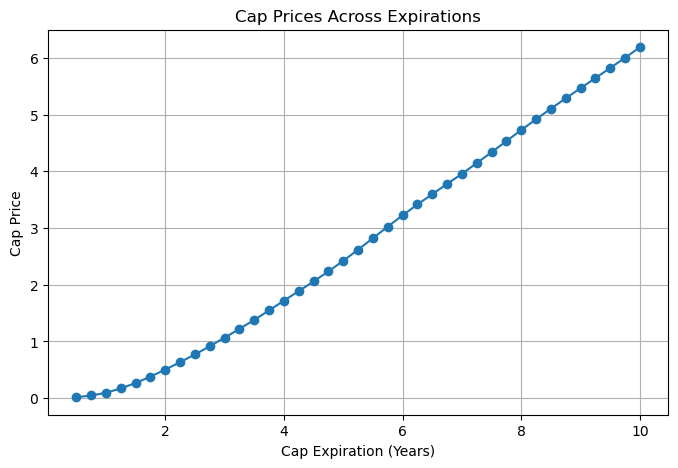

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(capcurves.index, capcurves['cap prices'], marker='o', linestyle='-')
plt.xlabel("Cap Expiration (Years)")
plt.ylabel("Cap Price")
plt.title("Cap Prices Across Expirations")
plt.grid()
plt.show()


### 3.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

In [71]:
capcurves[['flat vols', 'fwd vols']].iloc[1:]

,flat vols,fwd vols
tenor,,
0.50,0.101500,0.101500
0.75,0.116946,0.128478
1.00,0.132391,0.154562
1.25,0.159421,0.219138
1.50,0.180856,0.239613
1.75,0.197446,0.254106
2.00,0.209941,0.261605
2.25,0.219090,0.263323
2.50,0.225643,0.261958


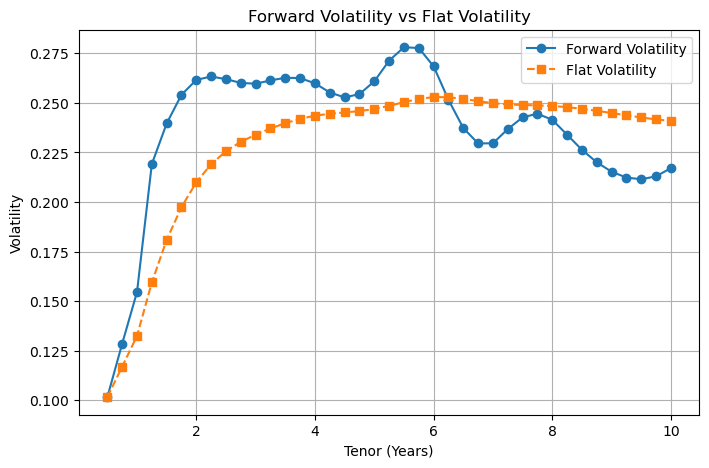

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(capcurves.index[1:], capcurves.loc[capcurves.index[1:], 'fwd vols'], marker='o', linestyle='-', label="Forward Volatility")
plt.plot(capcurves.index[1:], capcurves.loc[capcurves.index[1:], 'flat vols'], marker='s', linestyle='--', label="Flat Volatility")

plt.xlabel("Tenor (Years)")
plt.ylabel("Volatility")
plt.title("Forward Volatility vs Flat Volatility")
plt.legend()
plt.grid()
plt.show()


***